In [39]:
!pip install xgboost
!pip install lightgbm
!pip install catboost

In [0]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV

import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [0]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [0]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [0]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

**Пути к директориям и файлам**

In [0]:
# input
PREP_DATASET_PATH = 'course_project_train_prep_2.csv'

# output
MODEL_FILE_PATH = 'model.pkl'

### Загрузка подготовленных датасетов

**Загрузка данных**

In [0]:
df = pd.read_csv(PREP_DATASET_PATH)

**Выделение признакового описания и целевой переменной**

In [0]:
TARGET_NAME = 'Credit Default'
FEATURE_NAMES_SELECTED = ['Years in current job_1 year',
 'Years in current job_10+ years',
 'Years in current job_2 years',
 'Years in current job_3 years',
 'Years in current job_4 years',
 'Years in current job_5 years',
 'Years in current job_6 years',
 'Years in current job_7 years',
 'Years in current job_8 years',
 'Years in current job_9 years',
 'Years in current job_< 1 year',
 'Tax Liens_0.0',
 'Tax Liens_1.0',
 'Tax Liens_2.0',
 'Tax Liens_3.0',
 'Tax Liens_4.0',
 'Number of Open Accounts_10.0',
 'Number of Open Accounts_11.0',
 'Number of Open Accounts_12.0',
 'Number of Open Accounts_13.0',
 'Number of Open Accounts_14.0',
 'Number of Open Accounts_15.0',
 'Number of Open Accounts_16.0',
 'Number of Open Accounts_17.0',
 'Number of Open Accounts_18.0',
 'Number of Open Accounts_19.0',
 'Number of Open Accounts_2.0',
 'Number of Open Accounts_20.0',
 'Number of Open Accounts_21.0',
 'Number of Open Accounts_22.0',
 'Number of Open Accounts_23.0',
 'Number of Open Accounts_24.0',
 'Number of Open Accounts_25.0',
 'Number of Open Accounts_3.0',
 'Number of Open Accounts_4.0',
 'Number of Open Accounts_5.0',
 'Number of Open Accounts_6.0',
 'Number of Open Accounts_7.0',
 'Number of Open Accounts_8.0',
 'Number of Open Accounts_9.0',
 'Number of Credit Problems_0.0',
 'Number of Credit Problems_1.0',
 'Number of Credit Problems_2.0',
 'Number of Credit Problems_3.0',
 'Number of Credit Problems_4.0',
 'Bankruptcies_0.0',
 'Bankruptcies_1.0',
 'Bankruptcies_2.0',
 'Bankruptcies_nan',
 'Purpose_business loan',
 'Purpose_buy a car',
 'Purpose_buy house',
 'Purpose_debt consolidation',
 'Purpose_educational expenses',
 'Purpose_home improvements',
 'Purpose_major purchase',
 'Purpose_medical bills',
 'Purpose_moving',
 'Purpose_other',
 'Purpose_renewable energy',
 'Purpose_small business',
 'Purpose_take a trip',
 'Purpose_vacation',
 'Purpose_wedding',
 'Term_Long Term',
 'Term_Short Term',
 'Average amount on 1 account']

In [0]:
X = df[FEATURE_NAMES_SELECTED]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=211)

### Модель, полученная на предыдущем уроке

In [49]:
final_model = lgbm.LGBMClassifier(n_estimators=500, max_depth=10,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.98      0.91      4047
           1       0.90      0.54      0.67      1578

    accuracy                           0.85      5625
   macro avg       0.87      0.76      0.79      5625
weighted avg       0.86      0.85      0.84      5625

TEST

              precision    recall  f1-score   support

           0       0.77      0.91      0.84      1340
           1       0.59      0.32      0.42       535

    accuracy                           0.74      1875
   macro avg       0.68      0.62      0.63      1875
weighted avg       0.72      0.74      0.72      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1220  120
1                362  173


### Снижение степени переобучения

In [50]:
final_model = lgbm.LGBMClassifier(n_estimators=500, max_depth=10,
                                      l2_leaf_reg=10,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.98      0.91      4047
           1       0.90      0.54      0.67      1578

    accuracy                           0.85      5625
   macro avg       0.87      0.76      0.79      5625
weighted avg       0.86      0.85      0.84      5625

TEST

              precision    recall  f1-score   support

           0       0.77      0.91      0.84      1340
           1       0.59      0.32      0.42       535

    accuracy                           0.74      1875
   macro avg       0.68      0.62      0.63      1875
weighted avg       0.72      0.74      0.72      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1220  120
1                362  173


### Подбор оптимального размера выборки, кривая обучения

In [0]:
final_model = lgbm.LGBMClassifier(n_estimators=500, max_depth=10,
                                      l2_leaf_reg=10,
                                      silent=True, random_state=21)

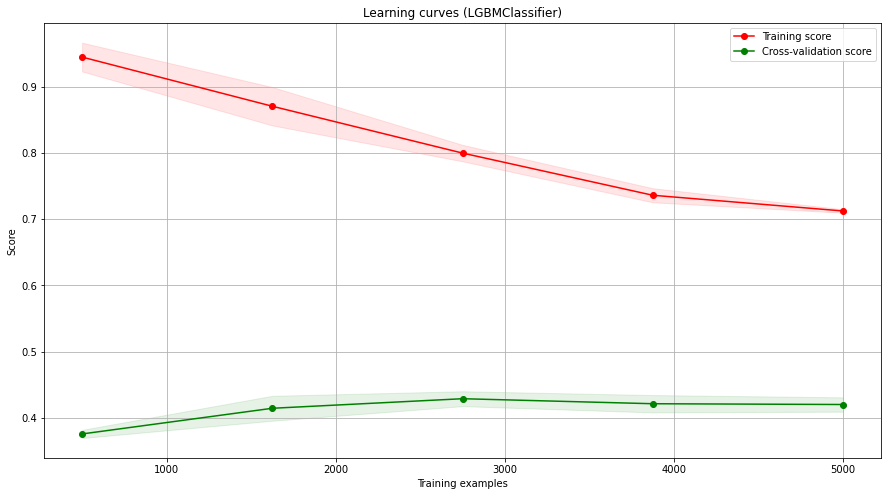

In [52]:
show_learning_curve_plot(final_model, X, y)

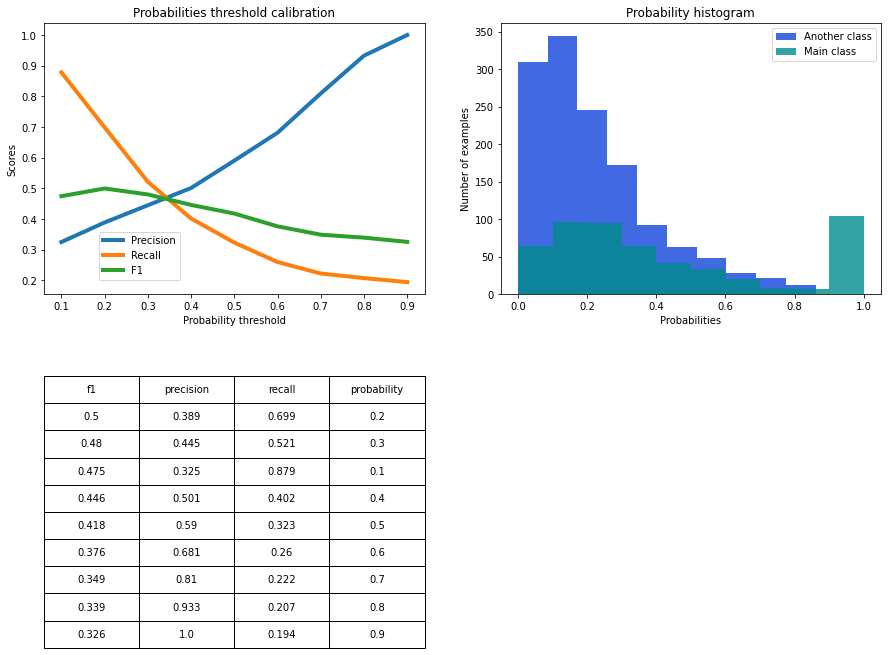

In [53]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

### Важность признаков

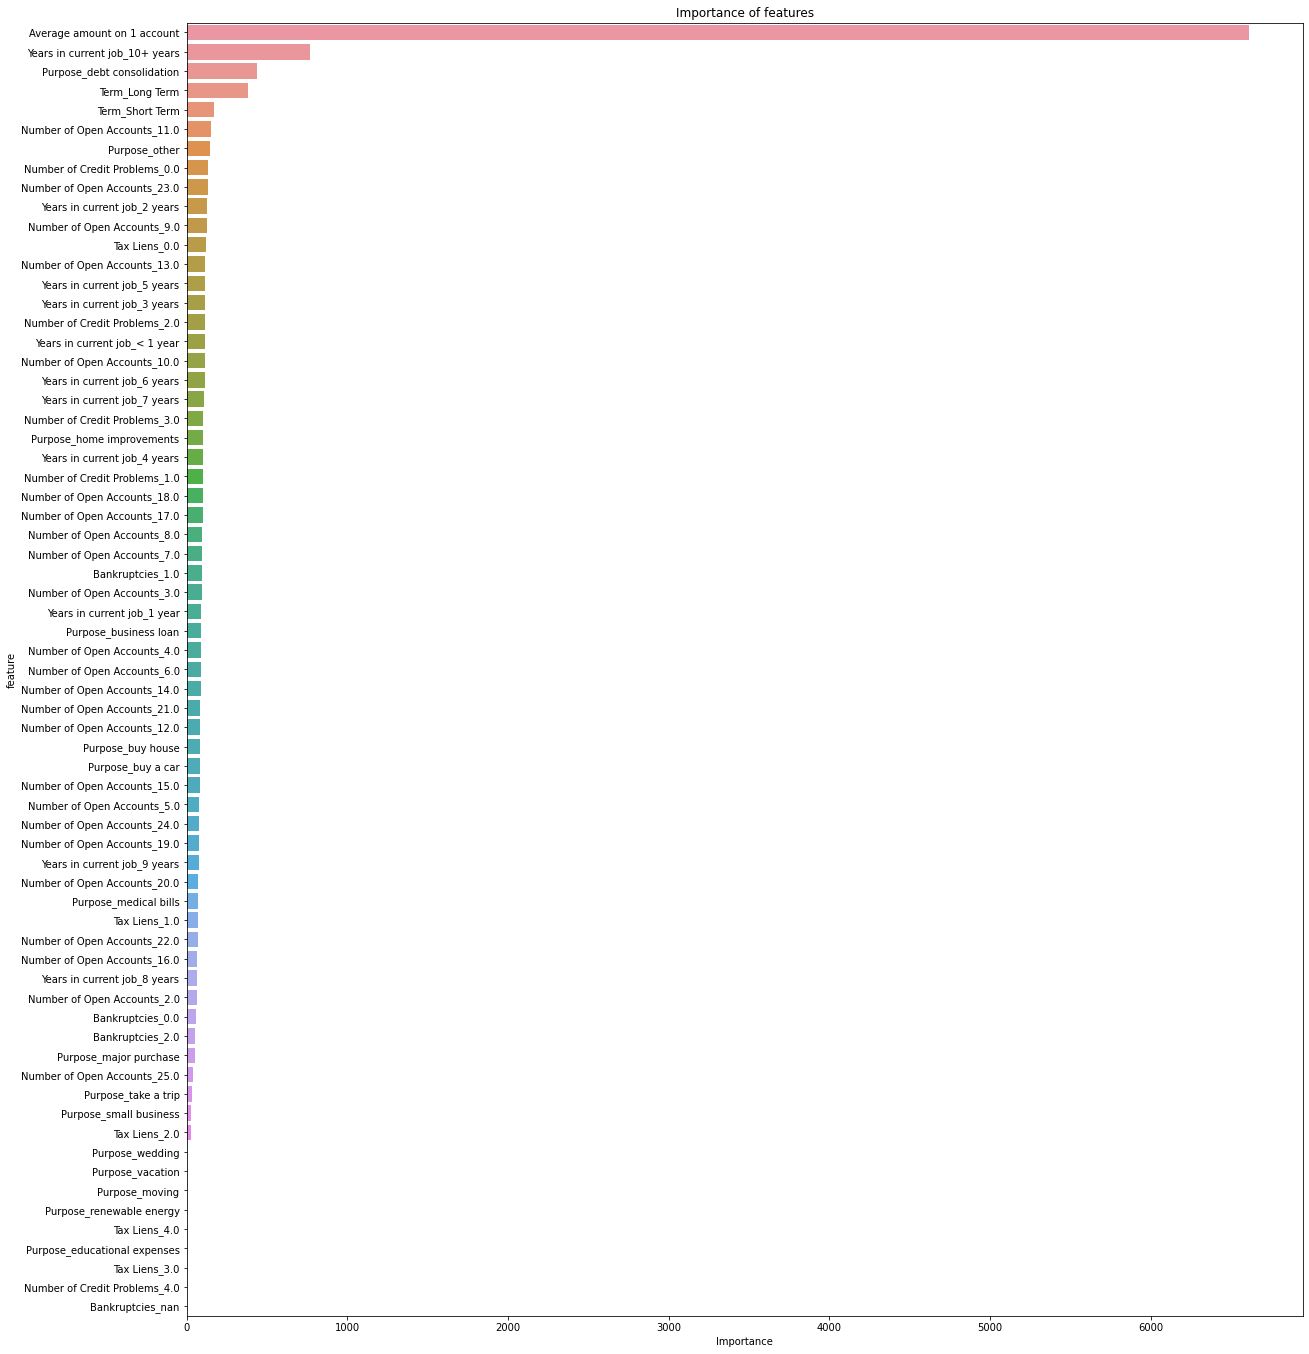

In [54]:
final_model.fit(X_train, y_train)

important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=25)

### Финальная модель

In [55]:
final_model = lgbm.LGBMClassifier(n_estimators=500, max_depth=10,
                                      l2_leaf_reg=10,
                                      silent=True, random_state=21)
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.83      0.98      0.90      4047
           1       0.89      0.50      0.64      1578

    accuracy                           0.84      5625
   macro avg       0.86      0.74      0.77      5625
weighted avg       0.85      0.84      0.83      5625

TEST

              precision    recall  f1-score   support

           0       0.76      0.92      0.83      1340
           1       0.59      0.29      0.39       535

    accuracy                           0.74      1875
   macro avg       0.68      0.61      0.61      1875
weighted avg       0.72      0.74      0.71      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1232  108
1                379  156


### Сохранение финальной модели

In [0]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)